# Supervised Learning for the Prediction of Firm Dynamics

"Supervised learning for the prediction of firm dynamics" by F.J. Bargagli-Stoffi, J. Niederreiter and M. Riccaboni in the book "Data Science for Economics and Finance: Methodologies and Applications" by S. Consoli, D. Reforgiato Recupero, M. Saisana

Here show how to implement the supervised learning routine to predict firms' bankruptcy on a dataset of Italian firms' financial accounts. The dataset is a small, random sample of real firm level data used by F.J. Bargagli-Stoffi, M. Riccaboni and A. Rungi for the main analysis of the paper "Machine learning for zombie hunting. Firms' failures, financial constraints, and misallocation". For more details on the predictors, we refer the reader to the original paper.

## A Simple Supervised Learning Routine

This simple step-by-step guide should aid the reader in designing a supervised learning (SL) routine to predict outcomes from input data.

1. Check that information on the outcome of interest is contained for the observations that are later used to train and test the SL algorithm, i.e. that the data set is labeled.

2. Prepare the matrix of input attributes to a machine-readable format.

    In case of missing values in the input attributes, this missingness has to be dealt with as it can impact results (see "Machine learning for zombie hunting. Firms' failures, financial constraints, and misallocation" by Bargagli-Stoffi, Riccaboni and Rungi for more information).
    In case it is ambiguous how to select the attributes used as input, the user might want to perform a feature selection step first (see this paper for more information).

 3. Choose how to split your data between training and testing set. Keep in mind that both training and testing set have to stay sufficiently large to train the algorithm or to validate its performance, respectively. Use resampling techniques in case of low data dimensions and stratified sampling whenever labels are highly unbalanced. If the data has a time dimension, make sure that the training set is formed by observations that occured before the ones in the testing set.

    Choose the SL algorithm that best suits your need. Possible dimensions to evaluate are prediction performance, simplicity of result interpretation and CPU runtime. Often a horserase between many algorithms is performed and the one with the highest prediction performance is chosen. There are already many algorithms already available "off the shelf".

    Train the algorithm using the training set only. In case hyper-parameters of the algorithm need to be set, choose them using crossfold validation on the training set, or better keep part of the training set only for hyperparameter tuning - but do not use the testing set until the algorithms are fully specified.

    Once the algorithm is trained, use it to predict the outcome on the testing set. Compare the predicted outcomes with the true outcomes.

    Choose the performance measure on which to evaluate the algorithm(s). Popular performance measures are Accuracy and Area Under the receiver operating Curve (AUC). Choose sensitive performance measure in case your data set is unbalanced such as Balanced Accuracy or the F-score.

    Once prediction performance has been assessed, the algorithm can be used to predict outcomes for observations for which the outcome is unknown. Note that valid predictions require that new observations should contain similar features and need to be independent from the outcome of old ones.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_excel("firmdynamics.xlsx")

In [4]:
data.head(2)

,consdummy,capital_intensity,failure,labour_product,fin_cons,inv,ICR_failure,NEG_VA,real_SA,Z_score,misallocated_fixed,profitability,area,zone,dummy_patents,dummy_trademark,financial_sustainability,car,liquidity_return,pension_tax_debts
0,0,8747.666992,1,53472.000000,0.183684,27780,1,0,-8.510027,2.210402,0,0,center,1,0,0,0.007091,0.589471,0.080847,8.039542e-05
1,1,373411.593750,1,123995.101562,0.138260,3156624,0,0,-13.442956,1.123584,0,0,center,1,0,0,0.012104,0.252539,0.051523,2.895906e-07


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   consdummy                 5000 non-null   int64  
 1   capital_intensity         5000 non-null   float64
 2   failure                   5000 non-null   int64  
 3   labour_product            5000 non-null   float64
 4   fin_cons                  5000 non-null   float64
 5   inv                       5000 non-null   int64  
 6   ICR_failure               5000 non-null   int64  
 7   NEG_VA                    5000 non-null   int64  
 8   real_SA                   5000 non-null   float64
 9   Z_score                   5000 non-null   float64
 10  misallocated_fixed        5000 non-null   int64  
 11  profitability             5000 non-null   int64  
 12  area                      5000 non-null   object 
 13  zone                      5000 non-null   int64  
 14  dummy_pa

In [129]:
data.isnull().sum()

consdummy                   0
capital_intensity           0
failure                     0
labour_product              0
fin_cons                    0
inv                         0
ICR_failure                 0
NEG_VA                      0
real_SA                     0
Z_score                     0
misallocated_fixed          0
profitability               0
area                        0
zone                        0
dummy_patents               0
dummy_trademark             0
financial_sustainability    0
car                         0
liquidity_return            0
pension_tax_debts           0
dtype: int64

In [8]:
data.describe()

,consdummy,capital_intensity,failure,labour_product,fin_cons,inv,ICR_failure,NEG_VA,real_SA,Z_score,misallocated_fixed,profitability,zone,dummy_patents,dummy_trademark,financial_sustainability,car,liquidity_return,pension_tax_debts
count,5000.000000,5.000000e+03,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.011400,8.042315e+04,0.503000,4.964370e+04,3.587472e-01,4.034969e+05,0.324000,0.037400,-10.853426,1.488705,0.169400,0.069200,2.720000,0.09920,0.103000,0.017525,-0.431838,-3.133551,0.001028
std,0.106171,3.265397e+05,0.500041,2.552830e+05,3.948048e-01,5.701228e+06,0.468047,0.189759,1.540314,1.058691,0.375142,0.253819,0.944128,0.29896,0.303989,0.062415,139.127354,223.509833,0.065327
min,0.000000,0.000000e+00,0.000000,-1.617370e+07,9.995370e-07,-7.994934e+07,0.000000,0.000000,-17.649710,0.001156,0.000000,0.000000,1.000000,0.00000,0.000000,-0.086101,-9731.272461,-15804.500000,-0.000032
25%,0.000000,6.631912e+03,0.000000,2.579000e+04,3.239925e-02,4.810000e+02,0.000000,0.000000,-11.838598,0.804641,0.000000,0.000000,3.000000,0.00000,0.000000,0.001978,0.071924,0.000752,0.000016
50%,0.000000,2.399929e+04,1.000000,4.204085e+04,1.596647e-01,1.445800e+04,0.000000,0.000000,-10.722895,1.330870,0.000000,0.000000,3.000000,0.00000,0.000000,0.007111,0.290461,0.037416,0.000035
75%,0.000000,7.422807e+04,1.000000,6.493437e+04,7.620409e-01,1.087580e+05,1.000000,0.000000,-9.750983,1.925080,0.000000,0.000000,3.000000,0.00000,0.000000,0.018749,0.906612,0.083280,0.000079
max,1.000000,1.120913e+07,1.000000,2.888788e+06,1.000000e+00,1.910130e+08,1.000000,1.000000,-0.989961,9.000000,1.000000,1.000000,4.000000,1.00000,1.000000,2.512209,1224.616333,2.242602,4.618500


In [5]:
data.failure.value_counts()

1    2515
0    2485
Name: failure, dtype: int64

In [7]:
data.consdummy.value_counts()

0    4943
1      57
Name: consdummy, dtype: int64

### Preparing data

In [6]:
y = data['failure'].values

In [7]:
predictors = data[["consdummy", "capital_intensity", "labour_product", "fin_cons",
              "inv", "ICR_failure", "NEG_VA", "misallocated_fixed", "profitability",
              "real_SA", "Z_score", "zone", "dummy_patents", "dummy_trademark",
              "financial_sustainability", "car", "liquidity_return", "pension_tax_debts"]].values

In [8]:
features = data[["consdummy", "capital_intensity", "labour_product", "fin_cons",
              "inv", "ICR_failure", "NEG_VA", "misallocated_fixed", "profitability",
              "real_SA", "Z_score", "zone", "dummy_patents", "dummy_trademark",
              "financial_sustainability", "car", "liquidity_return", "pension_tax_debts"]]

In [9]:

from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(predictors, y, test_size = 0.25, random_state = 123)

## 2. Supervised Learning Algorithms

### 2.1 Decision Trees

#### Description

Decision trees commonly consist of a sequence of binary decision rules (nodes) on which the tree splits into branches (edges). At each final branch (leaf node) a decision regarding the outcome is estimated. The sequence of decision rules and the location of each cut-off point is based on minimizing a measure of node purity (e.g., Gini index, or entropy for classification tasks, mean-squared-error for regression tasks). Decision trees are easy to interpret but sensitive to changes in the feature space, frequently lowering their out of sample performance (see Breiman 2017 for a detailed introduction).

#### Example usage in Python

In [11]:
# Import the required libraries

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

Cross-Validation Results:
{'ccp_alphas': array([0.00000000e+00, 3.09627479e-05, 3.77933178e-05, 4.88017429e-05,
       5.67901235e-05, 6.05042017e-05, 7.04540315e-05, 7.61904762e-05,
       9.74712644e-05, 1.02716049e-04, 1.03150183e-04, 1.06257982e-04,
       1.18518519e-04, 1.25714286e-04, 1.46443050e-04, 1.49745433e-04,
       1.64444444e-04, 1.65925926e-04, 1.68219833e-04, 1.68421053e-04,
       1.71525181e-04, 1.74170692e-04, 1.88007055e-04, 1.95865633e-04,
       2.22003284e-04, 2.35570720e-04, 2.40306513e-04, 2.42914980e-04,
       2.47372863e-04, 2.51483561e-04, 2.55555556e-04, 2.57264438e-04,
       3.04602976e-04, 3.31294118e-04, 3.33333333e-04, 3.49206349e-04,
       3.55067742e-04, 3.60000000e-04, 3.65271102e-04, 3.80952381e-04,
       3.83141762e-04, 4.04546851e-04, 4.23529412e-04, 4.26128210e-04,
       4.29206349e-04, 4.31447246e-04, 4.34051282e-04, 4.34586466e-04,
       4.40845704e-04, 4.46082949e-04, 4.50048226e-04, 4.55608183e-04,
       4.61685215e-04, 4.61952862e-0

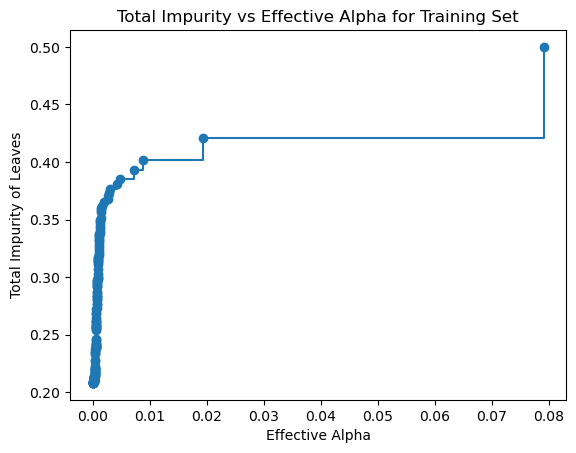

Detailed Summary:
10
50


In [12]:


# Grow the tree
dt = DecisionTreeClassifier(min_samples_split=30, ccp_alpha=0.001)
dt.fit(X_train, y_train)

# Display the results
print("Cross-Validation Results:")
print(dt.cost_complexity_pruning_path(X_train, y_train))

# Visualize cross-validation results
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
plt.figure()
plt.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
plt.xlabel("Effective Alpha")
plt.ylabel("Total Impurity of Leaves")
plt.title("Total Impurity vs Effective Alpha for Training Set")
plt.show()

# Detailed summary of splits
print("Detailed Summary:")
print(dt.get_depth())
print(dt.get_n_leaves())



In [ ]:

#pip install pydotplus

In [13]:
import graphviz

In [14]:
# Create attractive postscript plot of tree
# (scikit-learn does not directly support postscript plots, but you can save the tree as an image file instead)
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

In [ ]:
# Notice: You might need to uncomment and install the pydotplus and graphviz libraries if you have not installed these before
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

In [16]:
featureNames = features.columns

In [17]:
# Plot tree
plt.figure(figsize=(12, 8))
plot_title = "Classification Tree"
dt_dot_data = export_graphviz(dt, out_file=None, filled=True, rounded=True, special_characters=True, feature_names= featureNames)
graph = graphviz.Source(dt_dot_data)
graph.render('tree')  # Save the tree as PDF or PNG
graph.view()

'tree.pdf'

<Figure size 1200x800 with 0 Axes>

In [18]:
# Predicted outcomes Decision Tree
dt_pred = dt.predict(X_test)

In [22]:
y_test.shape

(1250,)

In [23]:
dt_pred.shape

(1250,)

In [19]:


# Generate table that compares true outcomes of the testing set with predicted outcomes of decision tree
dt_tab = pd.crosstab(y_test, dt_pred, rownames=['True'], colnames=['Predicted'])


# Calculate AUC value of predictions in the testing set
dt_auc = roc_auc_score(y_test, dt_pred)

In [20]:
dt_tab

Predicted,0,1
True,,
0,432,182
1,175,461


In [ ]:
#accuracy = (TP + TN)/N

In [17]:
dt_auc

0.7142129145924241

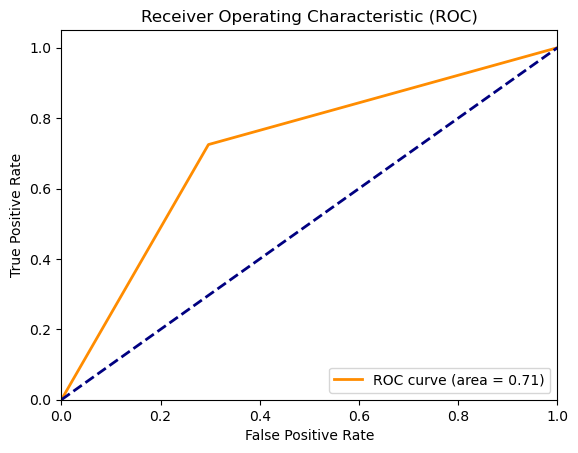

AUC value: 0.7142129145924241


In [21]:


# Generate ROC curve and calculate AUC value of predictions in the testing set
dt_roc_auc = roc_auc_score(y_test, dt_pred)
fpr, tpr, thresholds = roc_curve(y_test, dt_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC value
print("AUC value:", dt_roc_auc)

## 2.2 Random Forest

### Description

Instead of estimating just one DT, random forest resamples the training set observations to estimate multiple trees. For each tree at each node a sample of m predictors is chosen randomly from the feature space. To obtain the final prediction the outcomes all trees are averaged or in classification tasks the chosen by majority vote (see also the original contribution of Breiman, 2001)

### Example usage in Python

In [37]:
# Import the required libraries

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [23]:
# Assuming 'trainfeatures', 'trainoutcome', 'testfeatures', and 'testoutcome' are numpy arrays or pandas DataFrames

# Train the Random Forest
obj_rf = RandomForestClassifier(n_estimators=500, max_features=8, random_state=34)
obj_rf.fit(X_train, y_train)

# Get predicted values
rf_pred = obj_rf.predict(X_test)



In [24]:
rf_pred.shape

(1250,)

In [164]:
featureNames.shape

(18,)

In [25]:
# Generate table that compares true outcomes of the testing set with predicted outcomes of random forest
rf_tab = pd.crosstab(y_test, rf_pred, rownames=['True'], colnames=['Predicted'])


In [26]:
rf_tab 

Predicted,0,1
True,,
0,484,130
1,186,450


In [28]:
confmat = confusion_matrix(y_test, rf_pred)

In [29]:
confmat

array([[484, 130],
       [186, 450]], dtype=int64)

In [33]:
precision_score(y_test, rf_pred)

0.7758620689655172

In [34]:
(450)/(450+130)

0.7758620689655172

In [38]:
recall_score(y_test, rf_pred)

0.7075471698113207

In [39]:
450/(186+450)

0.7075471698113207

In [41]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.72      0.79      0.75       614
           1       0.78      0.71      0.74       636

    accuracy                           0.75      1250
   macro avg       0.75      0.75      0.75      1250
weighted avg       0.75      0.75      0.75      1250



In [167]:
# Generate ROC curve and calculate AUC value of predictions in the testing set
rf_prob = obj_rf.predict_proba(X_test)[:, 1]  # Probability of positive class
rf_roc_auc = roc_auc_score(y_test, rf_prob)

In [169]:
rf_prob

array([0.788, 0.176, 0.862, ..., 0.256, 0.412, 0.634])

In [168]:
rf_roc_auc

0.8148994632577387

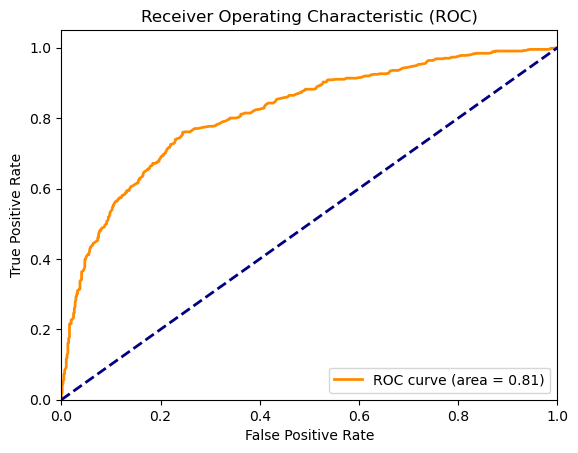

AUC value: 0.8148994632577387


In [170]:



fpr, tpr, thresholds = roc_curve(y_test, rf_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC value
print("AUC value:", rf_roc_auc)


#### Description

Support vector machines (SVM) & Support vector machine algorithms estimate a hyperplane over the feature space to classify observations. The vectors that span the hyperplane are called support vectors. They are chosen such that the overall distance (called margin) between the data points and the hyperplane as well as the prediction accuracy is maximized (see also Steinwart 2008).



In [108]:
# Import the required libraries
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [173]:



# Train the Support Vector Machine
obj_svm = SVC(probability=True)  # probability=True to enable probability estimates
obj_svm.fit(X_train, y_train)

# Get predicted values
svm_pred = obj_svm.predict(X_test)

# Generate table that compares true outcomes of the testing set with predicted outcomes of random forest
svm_tab = pd.crosstab(y_test, svm_pred, rownames=['True'], colnames=['Predicted'])

In [174]:
svm_tab

Predicted,0,1
True,,
0,94,520
1,52,584


In [177]:
# Generate ROC curve and calculate AUC value of predictions in the testing set
svm_prob = obj_svm.predict_proba(X_test)[:, 1]  # Probability of positive class
svm_roc_auc = roc_auc_score(y_test, svm_prob)


In [178]:
svm_roc_auc

0.6735321533198123

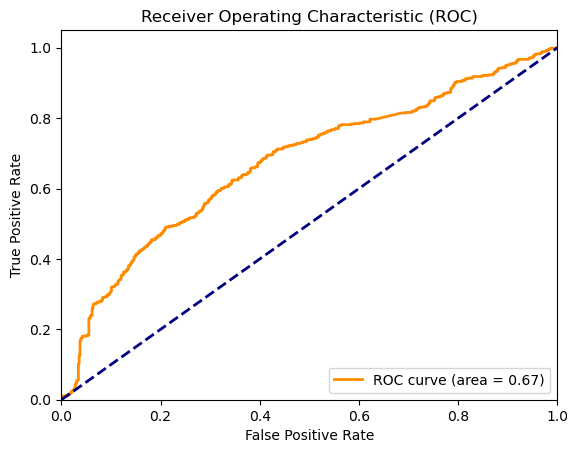

AUC value: 0.6735321533198123


In [179]:

fpr, tpr, thresholds = roc_curve(y_test, svm_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC value
print("AUC value:", svm_roc_auc)
